In [32]:
import numpy as np    
import matplotlib.pyplot as plt
import pandas as pd 

In [33]:
## import dataset
dataset = pd.read_csv("Mall_Customers.csv")
dataset

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [34]:
x = dataset.iloc[:, [3,4]]
x

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


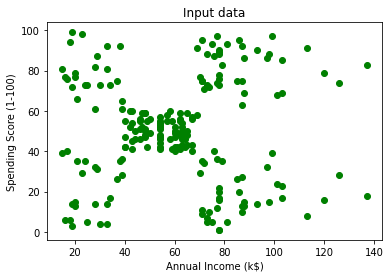

In [35]:
plt.scatter(x['Annual Income (k$)'], x['Spending Score (1-100)'], c='g')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title("Input data")
plt.show()

In [36]:
def initialize_centroids(k, data):
    n_dims = data.shape[1]
    centroid_min = data.min().min()
    centroid_max = data.max().max()
    centroids = []
    for centroid in range(k):
        centroid = np.random.uniform(centroid_min, centroid_max, n_dims)
        centroids.append(centroid)
    centroids = pd.DataFrame(centroids, columns= data.columns)
    return centroids

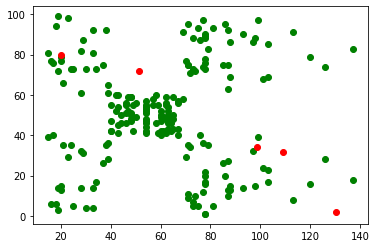

In [37]:
centroids = initialize_centroids(5, x)
plt.scatter(x['Annual Income (k$)'], x['Spending Score (1-100)'], c='g')
plt.scatter(centroids['Annual Income (k$)'], centroids['Spending Score (1-100)'], c="r")

In [38]:
def error(a,b):
# Given two numpy arrays, calculates the root of the sum of squared errors 
    err = np.square(np.sum((a-b)**2))
    return err

In [39]:
def assign_centroid(data, centroids):
#    Receives a dataframe of data and centroids and returns a list assigning each observation a centroid.
#    data: a dataframe with all data that will be used.
#    centroids: a dataframe with the centroids. For assignment the index will be used.
    n_observations = data.shape[0]
    centroid_assign = []
    centroid_errors = []
    k = centroids.shape[0]

    for observation in range(n_observations):
        errors = np.array([])
        for centroid in range(k):
            err = error(centroids.iloc[centroid, :2], data.iloc[observation, :2])
            errors = np.append(errors, err)

        closest_centroid = np.where(errors == np.amin(errors))[0].tolist()[0]  
        centroid_error = np.amin(errors)

        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)

    return (centroid_assign, centroid_errors)

In [40]:
# Assigning centroid to every value in dataframa
x['centroid'], x['error'] = assign_centroid(x.iloc[:,:2],centroids)
x[['centroid', 'error']].head

<ipython-input-40-710df92b12dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['centroid'], x['error'] = assign_centroid(x.iloc[:,:2],centroids)


<bound method NDFrame.head of      centroid         error
0           3  2.796200e+06
1           3  8.286495e+02
2           3  2.947498e+07
3           3  5.741357e+02
4           3  2.481813e+06
..        ...           ...
195         4  5.542910e+06
196         4  8.671352e+04
197         4  4.290355e+06
198         0  9.348164e+04
199         4  1.158497e+07

[200 rows x 2 columns]>

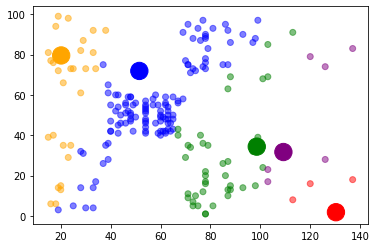

In [41]:
colors = {0:'red', 1:'blue', 2:'green', 3:'orange', 4:'purple'}

plt.scatter(x.iloc[:,0], x.iloc[:,1],  marker = 'o', c = x['centroid'].apply(lambda z: colors[z]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda z: colors[z]))

In [42]:
x['error'].sum()

460884454.49501103

In [43]:
# assigning centroid to be average (mean) of values in its cluster 
data_columns = ['Annual Income (k$)', 'Spending Score (1-100)']
centroids = x.groupby('centroid').agg('mean').loc[:,data_columns].reset_index(drop = True)
centroids

,Annual Income (k$),Spending Score (1-100)
0,123.333333,14.000000
1,57.942149,55.619835
2,83.325000,28.150000
3,22.766667,61.266667
4,119.166667,50.666667


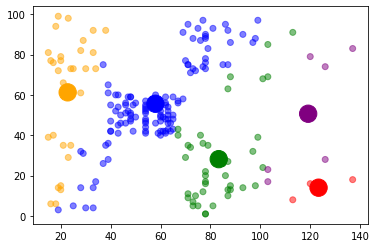

In [44]:
plt.scatter(x.iloc[:,0], x.iloc[:,1],  marker = 'o', c = x['centroid'].apply(lambda z: colors[z]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda z: colors[z]))

In [45]:
# function that iterates previous steps till error delta = 0
def knn(data, k):
    '''
    Given a dataset and number of clusters, it clusterizes the data. 
    data: a DataFrame with all information necessary
    k: number of clusters to create
    '''

    # Initialize centroids and error
    centroids = initialize_centroids(k, data)
    error = []
    compr = True
    i = 0

    while(compr):
        # Obtain centroids and error
        data['centroid'], iter_error = assign_centroid(data,centroids)
        error.append(sum(iter_error))
        # Recalculate centroids
        centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

        # Check if the error has decreased
        if(len(error)<2):
            compr = True
        else:
            if(round(error[i],3) !=  round(error[i-1],3)):
                compr = True
            else:
                compr = False
        i = i + 1 

    data['centroid'], iter_error = assign_centroid(data,centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)
    return (data['centroid'], iter_error, centroids)

In [ ]:
x['centroid'], _, centroids =  knn(x.drop(['centroid','error'], axis = 1),5)

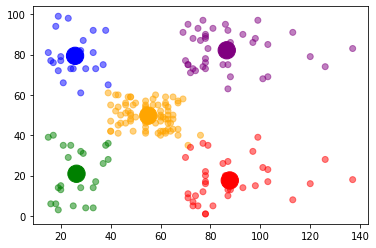

In [47]:
plt.scatter(x.iloc[:,0], x.iloc[:,1],  marker = 'o', c = x['centroid'].apply(lambda z: colors[z]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda z: colors[z]))